In [ ]:
DATASET

### Downalod data set from this URL
https://drive.google.com/drive/folders/1hyC0C1y4TULjIjW44E6q_BzxuL-Wmbs4?usp=sharing

IMPORTS

In [1]:
# Import necessary libraries for model implementation, data processing, and evaluation
# torch: Deep learning library
# torchvision: Provides computer vision utilities
# numpy: For numerical operations
# matplotlib: For visualization
import pickle
from torch.utils.data import DataLoader, Dataset
import os
import torch
from torchvision import transforms
from PIL import Image

import sys
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
import torch.nn.functional as F
import torch.distributed as dist
from torchvision import models
import torchmetrics
import numpy as np
from tqdm import tqdm
import os
import time
import json
from uuid import uuid4
from typing import List
from pathlib import Path
from torchvision.models import ResNet18_Weights

MATRYOKSHA FUNCTIONS

In [2]:
# Define the Matryoshka Linear Layer
# This layer supports multi-size outputs, allowing flexibility in model size.
# Each size has its classifier, enabling the model to output predictions at different granularities.
'''
Loss function for Matryoshka Representation Learning
'''
import torch
import torch.nn as nn

class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.tensor(self.relative_importance)
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=10, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            setattr(self, f'nesting_classifier_{0}', nn.Linear(nesting_list[-1], self.num_classes, **kwargs))
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f'nesting_classifier_{i}', nn.Linear(num_feat, self.num_classes, **kwargs))

    def reset_parameters(self):
        if self.efficient:
            self.nesting_classifier_0.reset_parameters()
        else:
            for i in range(len(self.nesting_list)):
                getattr(self, f'nesting_classifier_{i}').reset_parameters()

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                nesting_logits += (getattr(self, f'nesting_classifier_{0}')(x[:, :num_feat]),)
            else:
                nesting_logits += (getattr(self, f'nesting_classifier_{i}')(x[:, :num_feat]),)
        return nesting_logits

class FixedFeatureLayer(nn.Linear):
    def __init__(self, in_features, out_features, **kwargs):
        super(FixedFeatureLayer, self).__init__(in_features, out_features, **kwargs)

    def forward(self, x):
        # Ensure x, weight, and bias are on the same device
        device = self.weight.device
        x = x.to(device)
        weight = self.weight.to(device)
        if self.bias is not None:
            bias = self.bias.to(device)
            out = torch.matmul(x[:, :self.in_features], weight.t()) + bias
        else:
            out = torch.matmul(x[:, :self.in_features], weight.t())
        return out

nesting_list = [8, 16, 32, 64, 128, 256, 512]
fc_layer = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=True)

INPUTS


In [3]:
# Configuration settings for model training
# Define key hyperparameters and paths used for model training
pretrained = True  # Define pretrained for compatibility

'''
This code is directly taken from FFCV-Imagenet https://github.com/libffcv/ffcv-imagenet
and modified for MRL purpose.
'''
sys.path.append("../") # adding root folder to the path

torch.backends.cudnn.benchmark = True
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.profiler.profile(False)

config_file = 'rn50_configs/rn50_40_epochs.yaml'
model_fixed_feature = 2048
# train_dataset = os.environ['WRITE_DIR'] + '/train_500_0.50_90.ffcv'
# val_dataset = os.environ['WRITE_DIR'] + '/val_500_uncompressed.ffcv'
num_workers = 0
in_memory = True
logging_folder = 'D:/Fall2024/NeuralNetworkDeepLearning/Project/MiniProject/NNDL_MRL_MiniProject/working'
log_level = 0
world_size = 2
distributed = False
learning_rate = 0.425

arch='resnet18'
weights=ResNet18_Weights.DEFAULT if pretrained else None0
efficient=0
mrl=1
nesting_start=3
fixed_feature=512


min_res=160
max_res=160
end_ramp=0
start_ramp=0


step_ratio=0.1
step_length=30
lr_schedule_type='cyclic'
lr=0.5
lr_peak_epoch=2



folder=logging_folder


batch_size=512
resolution=224
lr_tta=1


eval_only=0
path=None
batch_size=512
optimizer='sgd'
momentum=0.9
weight_decay=4e-5
epochs=15
label_smoothing=0.1
distributed=0
use_blurpool=0



address='localhost'
port=12355



DATASET LOADING

In [4]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, label_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].transpose((1, 2, 0))  # Transpose to (32, 32, 3)
        label = self.labels[idx]
        image = Image.fromarray(image.astype('uint8'))  # Convert to PIL Image
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='latin1')
    data = batch['data']
    labels = batch['labels']
    data = data.reshape(-1, 3, 32, 32)  # Reshape data
    return data, labels

def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []
    for i in range(1, 6):
        batch_data, batch_labels = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        train_data.append(batch_data)
        train_labels.extend(batch_labels)
    train_data = np.vstack(train_data)
    train_labels = np.array(train_labels)
    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    test_data = test_data.reshape(-1, 3, 32, 32)
    test_labels = np.array(test_labels)
    return train_data, train_labels, test_data, test_labels

data_dir = 'data/cifar-10-batches-py/'  # Modify with actual path
train_data, train_labels, test_data, test_labels = load_cifar10_data(data_dir)

this_device = f'cuda:{0}'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), #newly added
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
def label_transform(label):
    # Transform labels to tensor
    # return torch.tensor(label, dtype=torch.long).to(this_device, non_blocking=True)
    return torch.tensor(label, dtype=torch.long)

train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform_train, label_transform=label_transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform_test, label_transform=label_transform)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=12)
# val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=12)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

HELPER FNS

In [5]:
CIFAR_MEAN = np.array([0.485, 0.456, 0.406]) * 255
CIFAR_STD = np.array([0.229, 0.224, 0.225]) * 255
DEFAULT_CROP_RATIO = 224/256

def get_step_lr(epoch, lr=lr, step_ratio=step_ratio, step_length=step_length, epochs=epochs):
    if epoch >= epochs:
        return 0

    num_steps = epoch // step_length
    return step_ratio**num_steps * lr

def get_constant_lr(epoch, lr=lr):
    return lr

def get_cyclic_lr(epoch, lr=lr, epochs=epochs, lr_peak_epoch=lr_peak_epoch):
    xs = [0, lr_peak_epoch, epochs]
    ys = [1e-4 * lr, lr, 0]
    return np.interp([epoch], xs, ys)[0]

class BlurPoolConv2d(torch.nn.Module):
    def __init__(self, conv):
        super().__init__()
        default_filter = torch.tensor([[[[1, 2, 1], [2, 4, 2], [1, 2, 1]]]]) / 16.0
        filt = default_filter.repeat(conv.in_channels, 1, 1, 1)
        self.conv = conv
        self.register_buffer('blur_filter', filt)

    def forward(self, x):
        blurred = F.conv2d(x, self.blur_filter, stride=1, padding=(1, 1),
                           groups=self.conv.in_channels, bias=None)
        return self.conv.forward(blurred)


CIFARTrainer

In [6]:
# Configuration settings for model training
# Define key hyperparameters and paths used for model training
pretrained = True  # Define pretrained for compatibility

class CIFARTrainer:
    def __init__(self, gpu, mrl=mrl, efficient=efficient,train_loader = train_loader, val_loader=val_loader,distributed=distributed, nesting_start=nesting_start, fixed_feature=fixed_feature,
                 this_device=  this_device):
        # self.all_params = get_current_config();
        self.gpu = gpu
        self.efficient = efficient
        self.nesting = (self.efficient or mrl)
        self.nesting_start = nesting_start
        self.nesting_list = [2**i for i in range(self.nesting_start, 10)] if self.nesting else None
        self.fixed_feature=fixed_feature
        self.uid = str(uuid4())
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.this_device = this_device


        if distributed:
            self.setup_distributed()

        self.model, self.scaler = self.create_model_and_scaler()
        # self.model.cuda().half()
        self.create_optimizer()
        self.initialize_logger()


    def setup_distributed(self, address=address, port=port, world_size=world_size):
        os.environ['MASTER_ADDR'] = address
        os.environ['MASTER_PORT'] = port

        dist.init_process_group("nccl", rank=self.gpu, world_size=world_size)
        torch.cuda.set_device(self.gpu)

    def cleanup_distributed(self):
        dist.destroy_process_group()

    def get_lr(self, epoch, lr_schedule_type=lr_schedule_type):
        lr_schedules = {
            'cyclic': get_cyclic_lr,
            'step': get_step_lr,
            'constant': get_constant_lr
        }

        return lr_schedules[lr_schedule_type](epoch)

    # resolution tools
    def get_resolution(self, epoch, min_res=min_res, max_res=max_res, end_ramp=end_ramp, start_ramp=start_ramp):
        assert min_res <= max_res

        if epoch <= start_ramp:
            return min_res

        if epoch >= end_ramp:
            return max_res

        # otherwise, linearly interpolate to the nearest multiple of 32
        interp = np.interp([epoch], [start_ramp, end_ramp], [min_res, max_res])
        final_res = int(np.round(interp[0] / 32)) * 32
        return final_res

    def create_optimizer(self, momentum=momentum, optimizer=optimizer, weight_decay=weight_decay,
                         label_smoothing=label_smoothing):
        assert optimizer == 'sgd'

        # Only do weight decay on non-batchnorm parameters
        all_params = list(self.model.named_parameters())
        bn_params = [v for k, v in all_params if ('bn' in k)]
        other_params = [v for k, v in all_params if not ('bn' in k)]
        param_groups = [{
            'params': bn_params,
            'weight_decay': 0.
        }, {
            'params': other_params,
            'weight_decay': weight_decay
        }]

        self.optimizer = torch.optim.SGD(param_groups, lr=1, momentum=momentum)
        # Adding Nesting Case....
        if self.nesting:
            self.loss = Matryoshka_CE_Loss(label_smoothing=label_smoothing)
        else:
            self.loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    def train(self, epochs=epochs, log_level=log_level):
        for epoch in range(epochs):
            print("epoch no. ", epoch)
            # res = self.get_resolution(epoch)
            # self.decoder.output_size = (res, res)
            train_loss = self.train_loop(epoch)

            if log_level > 0:
                extra_dict = {
                    'train_loss': train_loss,
                    'epoch': epoch
                }

                self.eval_and_log(extra_dict)

        # self.eval_and_log({'epoch':epoch})
        if self.gpu == 0:
            torch.save(self.model.state_dict(), self.log_folder / 'final_weights.pt')

    def eval_and_log(self, extra_dict={}):
        start_val = time.time()
        if self.nesting:
            stats = self.val_loop_nesting()
        else:
            stats = self.val_loop()
        val_time = time.time() - start_val

        if self.gpu == 0:
            d = {
                'current_lr': self.optimizer.param_groups[0]['lr'], 'val_time': val_time
            }
            for k in stats.keys():
                if k=='loss':
                    continue
                else:
                    d[k]=stats[k]

            self.log(dict(d, **extra_dict))

        return stats

    def create_model_and_scaler(self, arch=arch, weights=ResNet18_Weights.DEFAULT if pretrained else Nonepretrained, distributed=distributed, use_blurpool=use_blurpool):
        '''
        Nesting Start is just the log_2 {smallest dim} unit. In our work we used powers of two, however this part can be changed easily.
        If we do not want to use MRL, we just keep both the efficient and mrl flags to 0
        If we want a fixed feature baseline, then we just change fixed_feature={Rep. Size of your choice}

        NOTE: FFCV Uses Blurpool.
        '''

        scaler = GradScaler()
        model = getattr(models, arch)(weights=ResNet18_Weights.DEFAULT if pretrained else Nonepretrained)
#         for name, param in model.named_parameters():
#             print(f"Layer: {name} | Size: {param.size()} | Total parameters: {param.numel()}")
        if self.nesting:
            ff= "MRL-E" if self.efficient else "MRL"
            print(f"Creating classification layer of type :\t {ff}")
            model.fc = MRL_Linear_Layer(self.nesting_list, num_classes=10, efficient=self.efficient)
        elif self.fixed_feature != 512:
            print("Using Fixed Features.... ")
            model.fc =  FixedFeatureLayer(self.fixed_feature, 10)

        def apply_blurpool(mod: torch.nn.Module):
            for (name, child) in mod.named_children():
                if isinstance(child, torch.nn.Conv2d) and (np.max(child.stride) > 1 and child.in_channels >= 16):
                    setattr(mod, name, BlurPoolConv2d(child))
                else: apply_blurpool(child)
        if use_blurpool: apply_blurpool(model)

        model = model.to(memory_format=torch.channels_last)
        model = model.to(self.gpu)
        
        if distributed:
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[self.gpu])
#         print("name_parameters_size ")
#         print(model.named_parameters().shape)
#         print("after")
#         for name, param in model.named_parameters():
#             print(f"Layer: {name} | Size: {param.size()} | Total parameters: {param.numel()}")
        return model, scaler

    def train_loop(self, epoch, log_level=log_level):
        model = self.model
        model.train()
        losses = []

        lr_start, lr_end = self.get_lr(epoch), self.get_lr(epoch + 1)
        iters = len(self.train_loader)
        lrs = np.interp(np.arange(iters), [0, iters], [lr_start, lr_end])

        iterator = tqdm(self.train_loader)
        for ix, (images, target) in enumerate(iterator):
            images = images.to(self.this_device, non_blocking=True)
            target = target.to(self.this_device, non_blocking=True)
            ### Training start
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lrs[ix]

            self.optimizer.zero_grad(set_to_none=True)
            with autocast():
                # images = images.cuda().half()

                output = self.model(images)
                loss_train = self.loss(output, target)

            self.scaler.scale(loss_train).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            ### Training end

            ### Logging start
            if log_level > 0:
                losses.append(loss_train.detach())

                group_lrs = []
                for _, group in enumerate(self.optimizer.param_groups):
                    group_lrs.append(f'{group["lr"]:.3f}')

                names = ['ep', 'iter', 'shape', 'lrs']
                values = [epoch, ix, tuple(images.shape), group_lrs]
                if log_level > 1:
                    names += ['loss']
                    values += [f'{loss_train.item():.3f}']

                msg = ', '.join(f'{n}={v}' for n, v in zip(names, values))
                iterator.set_description(msg)
            ### Logging end

        if log_level > 0:
            loss = torch.stack(losses).mean().cpu()
            assert not torch.isnan(loss), 'Loss is NaN!'
            return loss.item()

    def val_loop(self, lr_tta=lr_tta):
        model = self.model
        model.eval()

        with torch.no_grad():
            with autocast():
                for images, target in tqdm(self.val_loader):
                    images = images.to(self.this_device, non_blocking=True)
                    target = target.to(self.this_device, non_blocking=True)
                    images = images.cuda().half()
                    output = self.model(images)
                    if lr_tta:
                        output += self.model(torch.flip(images, dims=[3]))

                    for k in ['top_1', 'top_5']:
                        self.val_meters[k](output, target)

                    loss_val = self.loss(output, target)
                    self.val_meters['loss'](loss_val)

        stats = {k: m.compute().item() for k, m in self.val_meters.items()}
        [meter.reset() for meter in self.val_meters.values()]
        return stats


    def val_loop_nesting(self, lr_tta=lr_tta):
        '''
        Since Nested Layers will give a tuple of logits, we have a different subroutine for validation.
        '''

        model = self.model
        model.eval()
        with torch.no_grad():
            with autocast():
                for images, target in tqdm(self.val_loader):
                    images = images.to(self.this_device, non_blocking=True)
                    target = target.to(self.this_device, non_blocking=True)
                    output = self.model(images); output=torch.stack(output, dim=0)

                    if lr_tta:
                        output +=torch.stack(self.model(torch.flip(images, dims=[3])), dim=0) # Just one augmentation.

                    # Logging the accuracies top1/5 for each of nesting...
                    for i in range(len(self.nesting_list)):
                        s = "top_1_{}".format(self.nesting_list[i])
                        self.val_meters[s](output[i], target)
                        s = "top_5_{}".format(self.nesting_list[i])
                        self.val_meters[s](output[i], target)

                    loss_val = self.loss(output, target)
                    self.val_meters['loss'](loss_val)

        stats = {k: m.compute().item() for k, m in self.val_meters.items()}
        [meter.reset() for meter in self.val_meters.values()]
        return stats


    def initialize_logger(self, folder=folder):
        if self.nesting:
            self.val_meters={}
            for i in self.nesting_list:
                self.val_meters['top_1_{}'.format(i)] = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(self.gpu)

            for i in self.nesting_list:
                self.val_meters['top_5_{}'.format(i)] = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(self.gpu)

            self.val_meters['loss'] = MeanScalarMetric().to(self.gpu)

        else:
            self.val_meters = {
                'top_1': torchmetrics.Accuracy(task='multiclass', num_classes=10).to(self.gpu),
                'top_5': torchmetrics.Accuracy(task='multiclass', top_k=5, num_classes=10).to(self.gpu),
                'loss': MeanScalarMetric().to(self.gpu)
            }

        if self.gpu == 0:
            folder = (Path(folder) / str(self.uid)).absolute()
            folder.mkdir(parents=True)

            self.log_folder = folder
            self.start_time = time.time()

            print(f'=> Logging in {self.log_folder}')
            # params = {
            #     '.'.join(k): self.all_params[k] for k in self.all_params.entries.keys()
            # }

            # with open(folder / 'params.json', 'w+') as handle:
            #     json.dump(params, handle)

    def log(self, content):
        print(f'=> Log: {content}')
        if self.gpu != 0: return
        cur_time = time.time()
        with open(self.log_folder / 'log', 'a+') as fd:
            fd.write(json.dumps({
                'timestamp': cur_time,
                'relative_time': cur_time - self.start_time,
                **content
            }) + '\n')
            fd.flush()

    @classmethod
    def launch_from_args(cls, mrl, efficient, world_size=2, eval_only=0):
        return cls.exec(0, eval_only, mrl, efficient)

    @classmethod
    def _exec_wrapper(cls, *args, **kwargs):
        make_config(quiet=True)
        cls.exec(*args, **kwargs)

    @classmethod
    def exec(cls, gpu, eval_only=eval_only, mrl=0, efficient=0, path=None):
        trainer = cls(gpu=gpu)
        if eval_only:
            print("Loading Model....."); ckpt = torch.load(path, map_location="cuda:{}".format(gpu))
            trainer.model.load_state_dict(ckpt); print("Loading Complete!")
            trainer.eval_and_log()
        else:
            trainer.train()
        return trainer.model

# Utils
class MeanScalarMetric(torchmetrics.Metric):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.add_state('sum', default=torch.tensor(0.), dist_reduce_fx='sum')
        self.add_state('count', default=torch.tensor(0), dist_reduce_fx='sum')

    def update(self, sample: torch.Tensor):
        self.sum += sample.sum()
        self.count += sample.numel()

    def compute(self):
        return self.sum.float() / self.count




In [7]:
model_base = CIFARTrainer.launch_from_args(0, 0, world_size, eval_only)


Creating classification layer of type :	 MRL
=> Logging in D:\Fall2024\NeuralNetworkDeepLearning\Project\MiniProject\NNDL_MRL_MiniProject\working\cd655737-01cf-4e6d-85b8-258dc5c64fa5
epoch no.  0


100%|██████████| 391/391 [00:50<00:00,  7.73it/s]


epoch no.  1


100%|██████████| 391/391 [00:49<00:00,  7.85it/s]


epoch no.  2


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]


epoch no.  3


100%|██████████| 391/391 [00:51<00:00,  7.63it/s]


epoch no.  4


100%|██████████| 391/391 [00:50<00:00,  7.76it/s]


epoch no.  5


100%|██████████| 391/391 [00:50<00:00,  7.81it/s]


epoch no.  6


100%|██████████| 391/391 [00:45<00:00,  8.67it/s]


epoch no.  7


100%|██████████| 391/391 [00:50<00:00,  7.77it/s]


epoch no.  8


100%|██████████| 391/391 [00:50<00:00,  7.69it/s]


epoch no.  9


100%|██████████| 391/391 [00:52<00:00,  7.48it/s]


epoch no.  10


100%|██████████| 391/391 [00:49<00:00,  7.93it/s]


epoch no.  11


100%|██████████| 391/391 [00:50<00:00,  7.70it/s]


epoch no.  12


100%|██████████| 391/391 [00:49<00:00,  7.87it/s]


epoch no.  13


100%|██████████| 391/391 [00:52<00:00,  7.49it/s]


epoch no.  14


100%|██████████| 391/391 [00:50<00:00,  7.71it/s]


In [8]:
model_mrl = CIFARTrainer.launch_from_args(1, 1, world_size, eval_only)

Creating classification layer of type :	 MRL
=> Logging in D:\Fall2024\NeuralNetworkDeepLearning\Project\MiniProject\NNDL_MRL_MiniProject\working\a1fcf1ed-0510-4a65-bb57-e6509235c14d
epoch no.  0


100%|██████████| 391/391 [00:49<00:00,  7.89it/s]


epoch no.  1


100%|██████████| 391/391 [00:50<00:00,  7.69it/s]


epoch no.  2


100%|██████████| 391/391 [00:50<00:00,  7.68it/s]


epoch no.  3


100%|██████████| 391/391 [00:50<00:00,  7.81it/s]


epoch no.  4


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]


epoch no.  5


100%|██████████| 391/391 [00:44<00:00,  8.80it/s]


epoch no.  6


100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


epoch no.  7


100%|██████████| 391/391 [00:49<00:00,  7.83it/s]


epoch no.  8


100%|██████████| 391/391 [00:49<00:00,  7.90it/s]


epoch no.  9


100%|██████████| 391/391 [00:49<00:00,  7.95it/s]


epoch no.  10


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


epoch no.  11


100%|██████████| 391/391 [00:50<00:00,  7.72it/s]


epoch no.  12


100%|██████████| 391/391 [00:50<00:00,  7.75it/s]


epoch no.  13


100%|██████████| 391/391 [00:51<00:00,  7.53it/s]


epoch no.  14


100%|██████████| 391/391 [00:51<00:00,  7.64it/s]


In [9]:
model_base.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
model_mrl.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

EVALUATE

In [11]:
def evaluate_model(model, dataloader, rep_size=0, show_progress_bar=True, notebook_progress_bar=False, nesting_list=None, tta=False, imagenetA=False, imagenetO=False, imagenetR=False):
	if nesting_list is None:
		return evaluate_model_ff(model, dataloader, rep_size, show_progress_bar, notebook_progress_bar, tta=tta, imagenetA=imagenetA, imagenetO=imagenetO, imagenetR=imagenetR)
	else:
		return evaluate_model_nesting(model, dataloader, show_progress_bar=True, nesting_list=nesting_list, tta=tta, imagenetA=imagenetA, imagenetO=imagenetO, imagenetR=imagenetR)


def evaluate_model_ff(model, data_loader, rep_size, show_progress_bar=False, notebook_progress_bar=False, tta=False, imagenetA=False, imagenetO=False, imagenetR=False):
    torch.backends.cudnn.benchmark = True
    num_images = 0
    num_top1_correct = 0
    num_top5_correct = 0
    predictions = []; m_score_dict={}; softmax=[]; gt=[]; all_logits=[]
    start = timer()
    model.fc = FixedFeatureLayer(rep_size, 10)
    with torch.no_grad():
        enumerable = enumerate(data_loader)
        if show_progress_bar:
            total = int(math.ceil(len(data_loader.dataset) / data_loader.batch_size))
            desc = 'Batch'
            if notebook_progress_bar:
                enumerable = tqdm.tqdm_notebook(enumerable, total=total, desc=desc)
            else:
                enumerable = tqdm(enumerable, total=total, desc=desc)
        for ii, (img_input, target) in enumerable:
            gt.append(target)
            unique_labels = torch.unique(target)
            img_input = img_input.cuda(non_blocking=True)
            logits = model(img_input)
            
            # Only stack if logits is a list or tuple, otherwise use it directly
            if isinstance(logits, (list, tuple)):
                logits = torch.stack(logits, dim=0)

            probs = F.softmax(logits, dim=-1); softmax.append(probs)
            m_score = margin_score(logits)
            print("m_score shape ", m_score.shape)
            for y in unique_labels:
                y = y.item()
                temp = target == y
                print("temp shape ", temp.shape)
                m_ = m_score[temp]
                if not (y in m_score_dict.keys()):
                    m_score_dict[y] = []
                m_score_dict[y].append(m_)

            _, output_index = logits.topk(k=5, dim=1, largest=True, sorted=True)
            output_index = output_index.cpu().numpy()
            predictions.append(output_index)
            for jj, correct_class in enumerate(target.cpu().numpy()):
                if correct_class == output_index[jj, 0]:
                    num_top1_correct += 1
                if correct_class in output_index[jj, :]:
                    num_top5_correct += 1
            num_images += len(target)
            all_logits.append(logits.cpu())
    end = timer()
    predictions = np.vstack(predictions)
    for k in m_score_dict.keys():
        m_score_dict[k] = torch.cat(m_score_dict[k])

    assert predictions.shape == (num_images, 5)
    return predictions, num_top1_correct / num_images, num_top5_correct / num_images, end - start, num_images, m_score_dict, torch.cat(softmax, dim=0), torch.cat(gt, dim=0), torch.cat(all_logits, dim=0)



def evaluate_model_nesting(model, data_loader, show_progress_bar=False, notebook_progress_bar=False, nesting_list=[2**i for i in range(3, 10)], tta=False, imagenetA= False, imagenetO=False, imagenetR=False):
	torch.backends.cudnn.benchmark = True

	num_images = 0
	num_top1_correct = {}
	num_top5_correct = {}
	predictions = {}; m_score_dict={};softmax=[]; gt=[]; all_logits=[]
	for i in nesting_list:
		m_score_dict[i]={}
		predictions[i]=[]
		num_top5_correct[i], num_top1_correct[i]=0,0
	start = timer()
	with torch.no_grad():
		enumerable = enumerate(data_loader)
		if show_progress_bar:
			total = int(math.ceil(len(data_loader.dataset) / data_loader.batch_size))
			desc = 'Batch'
			if notebook_progress_bar:
				enumerable = tqdm.tqdm_notebook(enumerable, total=total, desc=desc)
			else:
				enumerable = tqdm(enumerable, total=total, desc=desc)
		for ii, (img_input, target) in enumerable:
			gt.append(target)
			unique_labels= torch.unique(target)
			img_input = img_input.cuda(non_blocking=True)
			logits = model(img_input); logits=torch.stack(logits, dim=0)
			probs=F.softmax(logits, dim=-1); softmax.append(probs.cpu())

			m_score = margin_score(logits)
			print("m_score shape ", m_score.shape)
			for k, nesting in enumerate(nesting_list):
				for y in unique_labels:
					y=y.item()
					temp=target==y
# 					print("temp shape ", temp.shape)
					m_ = (m_score[k])[temp]
					if not (y in m_score_dict[nesting].keys()):
						m_score_dict[nesting][y]=[]
					m_score_dict[nesting][y].append(m_)

				_, output_index = logits[k].topk(k=5, dim=1, largest=True, sorted=True)
				output_index = output_index.cpu().numpy()
				predictions[nesting].append(output_index)
				for jj, correct_class in enumerate(target.cpu().numpy()):
					if correct_class == output_index[jj, 0]:
						num_top1_correct[nesting] += 1
					if correct_class in output_index[jj, :]:
						num_top5_correct[nesting] += 1
			num_images += len(target)
			all_logits.append(logits.cpu())

	end = timer()
	for nesting in nesting_list:
		predictions[nesting] = np.vstack(predictions[nesting])
		for k in m_score_dict[nesting].keys():
			m_score_dict[nesting][k]=torch.cat(m_score_dict[nesting][k])
			m_score_dict[nesting][k]=(m_score_dict[nesting][k].mean()).item()

		num_top5_correct[nesting]=num_top5_correct[nesting]/num_images
		num_top1_correct[nesting]=num_top1_correct[nesting]/num_images

		assert predictions[nesting].shape == (num_images, 5)
	return predictions, num_top1_correct, num_top5_correct, end - start, num_images, m_score_dict,torch.cat(softmax, dim=1), torch.cat(gt, dim=0), torch.cat(all_logits, dim=1)


def margin_score(y_pred):
	top_2 = torch.topk(F.softmax(y_pred, dim=-1), k=2, dim=-1)[0]
	if len(top_2.shape)>2:
		margin_score = 1- (top_2[:, :, 0]-top_2[:, :, 1])
	else:
		margin_score = 1- (top_2[:, 0]-top_2[:, 1])
	return margin_score



In [12]:
# Import necessary libraries for model implementation, data processing, and evaluation
# torch: Deep learning library
# torchvision: Provides computer vision utilities
# numpy: For numerical operations
# matplotlib: For visualization
from tqdm import tqdm
from timeit import default_timer as timer
import math

In [13]:
# _, top1_acc_mrl, top5_acc_mrl, total_time_mrl, num_images_mrl, m_score_dict_mrl, softmax_probs_mrl, gt_mrl, logits_mrl = evaluate_model(
# 				model_mrl, val_loader, rep_size= 0, show_progress_bar=False, nesting_list=nesting_list)

# tqdm.write('Evaluated {} images'.format(num_images_mrl))
# confidence_mrl, predictions_mrl = torch.max(softmax_probs_mrl, dim=-1)
# for i, nesting in enumerate(nesting_list):
#     print("Rep. Size", "\t", nesting, "\n")
#     tqdm.write('    Top-1 accuracy for {} : {:.2f}'.format(nesting, 100.0 * top1_acc_mrl[nesting]))
#     tqdm.write('    Top-5 accuracy for {} : {:.2f}'.format(nesting, 100.0 * top5_acc_mrl[nesting]))
#     tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_mrl, 1000.0 * total_time_mrl / num_images_mrl))

In [14]:
# _, top1_acc_base_8, top5_acc_base_8, total_time_base_8, num_images_base_8, m_score_dict_base_8, softmax_probs_base_8, gt_base_8, logits_base_8 = evaluate_model(
#     model_base, val_loader, 8, show_progress_bar=False, nesting_list=None
# )

# tqdm.write('Evaluated {} images'.format(num_images_base_8))
# confidence_base, predictions_base = torch.max(softmax_probs_base_8, dim=-1)

# print("Rep. Size", "\t", 8, "\n")
# tqdm.write('    Evaluated {} images'.format(num_images_base_8))
# tqdm.write('    Top-1 accuracy: {:.2f}%'.format(100.0 * top1_acc_base_8))
# tqdm.write('    Top-5 accuracy: {:.2f}%'.format(100.0 * top5_acc_base_8))
# tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_base_8, 1000.0 * total_time_base_8 / num_images_base_8))

In [15]:
_, top1_acc_base_16, top5_acc_base_16, total_time_base_16, num_images_base_16, m_score_dict_base_16, softmax_probs_base_16, gt_base_16, logits_base_16 = evaluate_model(
				model_base, val_loader, show_progress_bar=False, nesting_list=None)

tqdm.write('Evaluated {} images'.format(num_images_base_16))
confidence_base, predictions_base = torch.max(softmax_probs_base_16, dim=-1)

print("Rep. Size", "\t", 16, "\n")
tqdm.write('    Evaluated {} images'.format(num_images_base_16))
tqdm.write('    Top-1 accuracy: {:.2f}%'.format(100.0 * top1_acc_base_16))
tqdm.write('    Top-5 accuracy: {:.2f}%'.format(100.0 * top5_acc_base_16))
tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_base_16, 1000.0 * total_time_base_16 / num_images_base_16))


_, top1_acc_base_32, top5_acc_base_32, total_time_base_32, num_images_base_32, m_score_dict_base_32, softmax_probs_base_32, gt_base_32, logits_base_32 = evaluate_model(
				model_base, val_loader, show_progress_bar=False, nesting_list=None)

tqdm.write('Evaluated {} images'.format(num_images_base_32))
confidence_base, predictions_base = torch.max(softmax_probs_base_32, dim=-1)

print("Rep. Size", "\t", 32, "\n")
tqdm.write('    Evaluated {} images'.format(num_images_base_32))
tqdm.write('    Top-1 accuracy: {:.2f}%'.format(100.0 * top1_acc_base_32))
tqdm.write('    Top-5 accuracy: {:.2f}%'.format(100.0 * top5_acc_base_32))
tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_base_32, 1000.0 * total_time_base_32 / num_images_base_32))

_, top1_acc_base_64, top5_acc_base_64, total_time_base_64, num_images_base_64, m_score_dict_base_64, softmax_probs_base_64, gt_base_64, logits_base_64 = evaluate_model(
				model_base, val_loader, show_progress_bar=False, nesting_list=None)

tqdm.write('Evaluated {} images'.format(num_images_base_64))
confidence_base, predictions_base = torch.max(softmax_probs_base_64, dim=-1)

print("Rep. Size", "\t", 64, "\n")
tqdm.write('    Evaluated {} images'.format(num_images_base_64))
tqdm.write('    Top-1 accuracy: {:.2f}%'.format(100.0 * top1_acc_base_64))
tqdm.write('    Top-5 accuracy: {:.2f}%'.format(100.0 * top5_acc_base_64))
tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_base_64, 1000.0 * total_time_base_64 / num_images_base_64))


_, top1_acc_base_128, top5_acc_base_128, total_time_base_128, num_images_base_128, m_score_dict_base_128, softmax_probs_base_128, gt_base_128, logits_base_128 = evaluate_model(
				model_base, val_loader, show_progress_bar=False, nesting_list=None)

tqdm.write('Evaluated {} images'.format(num_images_base_128))
confidence_base, predictions_base = torch.max(softmax_probs_base_128, dim=-1)

print("Rep. Size", "\t", 128, "\n")
tqdm.write('    Evaluated {} images'.format(num_images_base_128))
tqdm.write('    Top-1 accuracy: {:.2f}%'.format(100.0 * top1_acc_base_128))
tqdm.write('    Top-5 accuracy: {:.2f}%'.format(100.0 * top5_acc_base_128))
tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_base_128, 1000.0 * total_time_base_128 / num_images_base_128))


_, top1_acc_base_256, top5_acc_base_256, total_time_base_256, num_images_base_256, m_score_dict_base_256, softmax_probs_base_256, gt_base_256, logits_base_256 = evaluate_model(
				model_base, val_loader, show_progress_bar=False, nesting_list=None)

tqdm.write('Evaluated {} images'.format(num_images_base_256))
confidence_base, predictions_base = torch.max(softmax_probs_base_256, dim=-1)

print("Rep. Size", "\t", 256, "\n")
tqdm.write('    Evaluated {} images'.format(num_images_base_256))
tqdm.write('    Top-1 accuracy: {:.2f}%'.format(100.0 * top1_acc_base_256))
tqdm.write('    Top-5 accuracy: {:.2f}%'.format(100.0 * top5_acc_base_256))
tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_base_256, 1000.0 * total_time_base_256 / num_images_base_256))



_, top1_acc_base_512, top5_acc_base_512, total_time_base_512, num_images_base_512, m_score_dict_base_512, softmax_probs_base_512, gt_base_512, logits_base_512 = evaluate_model(
				model_base, val_loader, show_progress_bar=False, nesting_list=None)

tqdm.write('Evaluated {} images'.format(num_images_base_512))
confidence_base, predictions_base = torch.max(softmax_probs_base_512, dim=-1)

print("Rep. Size", "\t", 512, "\n")
tqdm.write('    Evaluated {} images'.format(num_images_base_512))
tqdm.write('    Top-1 accuracy: {:.2f}%'.format(100.0 * top1_acc_base_512))
tqdm.write('    Top-5 accuracy: {:.2f}%'.format(100.0 * top5_acc_base_512))
tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_base_512, 1000.0 * total_time_base_512 / num_images_base_512))

C:\Users\navee\.conda\envs\fMRLRecEnv\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


m_score shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
m_score shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
m_score shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
m

In [16]:
# Import necessary libraries for model implementation, data processing, and evaluation
# torch: Deep learning library
# torchvision: Provides computer vision utilities
# numpy: For numerical operations
# matplotlib: For visualization

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Define multiple representation sizes
representation_sizes = [8, 16, 32, 64, 128, 256, 512]

# Initialize lists to collect Top-1 and Top-5 accuracies for each size
top1_accuracies = []
top5_accuracies = []

# Loop through each representation size and evaluate the model
for size in representation_sizes:
    _, top1_acc, top5_acc, total_time, num_images, m_score_dict, softmax_probs, gt, logits = evaluate_model(
        model_base, val_loader, size, show_progress_bar=False, nesting_list=None
    )
    top1_accuracies.append(100.0 * top1_acc)  # Convert to percentage
    top5_accuracies.append(100.0 * top5_acc)  # Convert to percentage
tqdm.write(f'Representation Size: {size}, Top-1 accuracy: {100.0 * top1_acc:.2f}%, Top-5 accuracy: {100.0 * top5_acc:.2f}%')

m_score shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
m_score shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
m_score shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
temp shape  torch.Size([128])
m

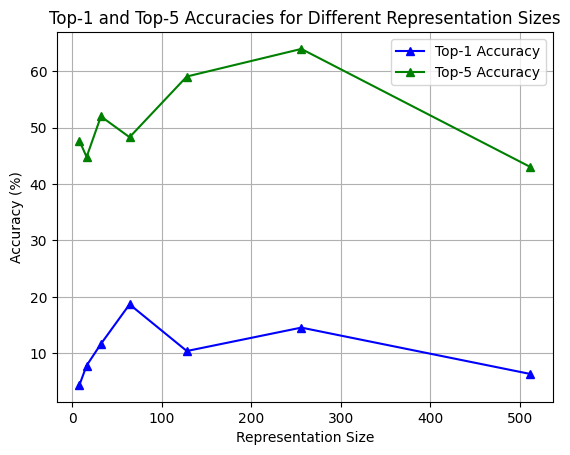

In [17]:
# Plot Top-1 and Top-5 Accuracies for Different Representation Sizes
plt.figure()
plt.plot(representation_sizes, top1_accuracies, marker='^', color='blue', label='Top-1 Accuracy')
plt.plot(representation_sizes, top5_accuracies, marker='^', color='green', label='Top-5 Accuracy')
plt.xlabel("Representation Size")
plt.ylabel("Accuracy (%)")
plt.title("Top-1 and Top-5 Accuracies for Different Representation Sizes")
plt.legend()
plt.grid(True) 
plt.show()

In [18]:
# Run the evaluation and get all relevant metrics
_, top1_acc_mrl, top5_acc_mrl, total_time_mrl, num_images_mrl, m_score_dict_mrl, softmax_probs_mrl, gt_mrl, logits_mrl = evaluate_model(
    model_mrl, val_loader, rep_size=0, show_progress_bar=False, nesting_list=nesting_list)

# Initialize lists to store accuracies for dynamic plotting
rep_sizes = []
top1_accuracies = []
top5_accuracies = []

# Display and store results for each nesting level
tqdm.write('Evaluated {} images'.format(num_images_mrl))
confidence_mrl, predictions_mrl = torch.max(softmax_probs_mrl, dim=-1)
for i, nesting in enumerate(nesting_list):
    print("Rep. Size", "\t", nesting, "\n")
    tqdm.write('    Top-1 accuracy for {} : {:.2f}'.format(nesting, 100.0 * top1_acc_mrl[nesting]))
    tqdm.write('    Top-5 accuracy for {} : {:.2f}'.format(nesting, 100.0 * top5_acc_mrl[nesting]))
    tqdm.write('    Total time: {:.1f}  (average time per image: {:.2f} ms)'.format(total_time_mrl, 1000.0 * total_time_mrl / num_images_mrl))
    
    # Append results to lists for plotting
    rep_sizes.append(nesting)
    top1_accuracies.append(100.0 * top1_acc_mrl[nesting])
    top5_accuracies.append(100.0 * top5_acc_mrl[nesting])

Batch:   3%|▎         | 2/79 [00:00<00:05, 13.29it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:   8%|▊         | 6/79 [00:00<00:04, 15.47it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  15%|█▌        | 12/79 [00:00<00:03, 16.92it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  20%|██        | 16/79 [00:00<00:03, 17.24it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  23%|██▎       | 18/79 [00:01<00:03, 17.32it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  28%|██▊       | 22/79 [00:01<00:03, 15.50it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  33%|███▎      | 26/79 [00:01<00:03, 13.95it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  35%|███▌      | 28/79 [00:01<00:03, 13.70it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  38%|███▊      | 30/79 [00:02<00:03, 12.51it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  43%|████▎     | 34/79 [00:02<00:03, 11.89it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  48%|████▊     | 38/79 [00:02<00:03, 13.37it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  54%|█████▍    | 43/79 [00:02<00:02, 15.55it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  57%|█████▋    | 45/79 [00:03<00:02, 15.61it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  65%|██████▍   | 51/79 [00:03<00:01, 16.44it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  70%|██████▉   | 55/79 [00:03<00:01, 17.23it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  72%|███████▏  | 57/79 [00:03<00:01, 16.23it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  81%|████████  | 64/79 [00:04<00:00, 18.02it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  84%|████████▎ | 66/79 [00:04<00:00, 16.04it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  89%|████████▊ | 70/79 [00:04<00:00, 15.94it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  94%|█████████▎| 74/79 [00:04<00:00, 15.81it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])


Batch:  99%|█████████▊| 78/79 [00:05<00:00, 14.74it/s]

m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 128])
m_score shape  torch.Size([7, 16])


Batch: 100%|██████████| 79/79 [00:05<00:00, 15.48it/s]

Evaluated 10000 images
Rep. Size 	 8 

    Top-1 accuracy for 8 : 57.48
    Top-5 accuracy for 8 : 94.22
    Total time: 5.1  (average time per image: 0.51 ms)
Rep. Size 	 16 

    Top-1 accuracy for 16 : 57.48
    Top-5 accuracy for 16 : 94.22
    Total time: 5.1  (average time per image: 0.51 ms)
Rep. Size 	 32 

    Top-1 accuracy for 32 : 60.93
    Top-5 accuracy for 32 : 95.55
    Total time: 5.1  (average time per image: 0.51 ms)
Rep. Size 	 64 

    Top-1 accuracy for 64 : 61.27
    Top-5 accuracy for 64 : 95.91
    Total time: 5.1  (average time per image: 0.51 ms)
Rep. Size 	 128 

    Top-1 accuracy for 128 : 61.80
    Top-5 accuracy for 128 : 96.31
    Total time: 5.1  (average time per image: 0.51 ms)
Rep. Size 	 256 

    Top-1 accuracy for 256 : 61.64
    Top-5 accuracy for 256 : 96.43
    Total time: 5.1  (average time per image: 0.51 ms)
Rep. Size 	 512 

    Top-1 accuracy for 512 : 61.86
    Top-5 accuracy for 512 : 96.33
    Total time: 5.1  (average time per image: 

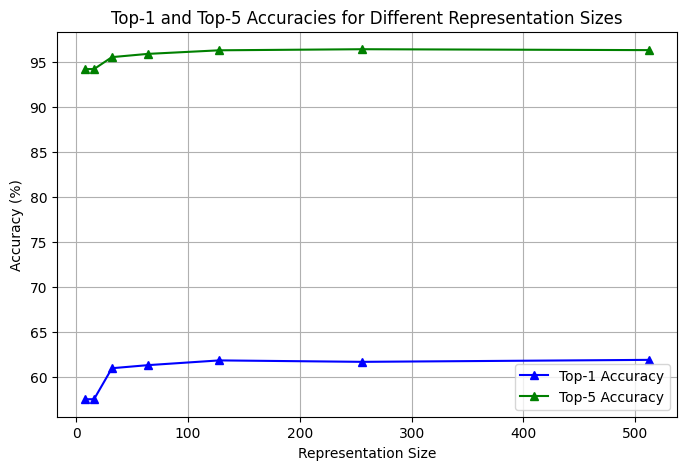

In [19]:
# Import necessary libraries for model implementation, data processing, and evaluation
# torch: Deep learning library
# torchvision: Provides computer vision utilities
# numpy: For numerical operations
# matplotlib: For visualization
import matplotlib.pyplot as plt

# Plot the accuracies
plt.figure(figsize=(8, 5))
plt.plot(rep_sizes, top1_accuracies, marker='^', label='Top-1 Accuracy', color='blue')
plt.plot(rep_sizes, top5_accuracies, marker='^', label='Top-5 Accuracy', color='green')

# Add titles and labels
plt.title('Top-1 and Top-5 Accuracies for Different Representation Sizes')
plt.xlabel('Representation Size')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from torch.utils.data import DataLoader, TensorDataset

# Example data for DataLoader (replace with actual data in real scenario)
num_samples = 100
num_features = 512

# Generate random features and labels
features = torch.randn(num_samples, num_features)
labels = torch.randint(0, 2, (num_samples,))  # Binary labels for simplicity

# Define a dataset and data loader
dataset = TensorDataset(features, labels)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define a function to create a model dynamically based on input dimension
class DynamicMRLModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(DynamicMRLModel, self).__init__()
        self.fc = torch.nn.Linear(input_dim, 1)  # Single output layer

    def forward(self, x):
        return self.fc(x).squeeze()

# Function to dynamically create the model based on required feature size
def create_model(input_dim):
    return DynamicMRLModel(input_dim)


In [21]:
# Helper functions to compute NDCG@k and Recall@k
def compute_ndcg(predictions, ground_truth, k=5):
    """
    Compute the normalized discounted cumulative gain (NDCG) at K.
    predictions: Predicted scores for each item (torch.Tensor).
    ground_truth: Binary tensor indicating if an item is relevant.
    """
    _, indices = torch.topk(predictions, k, sorted=True)
    dcg = 0.0
    for rank, idx in enumerate(indices, start=1):
        dcg += ground_truth[idx].item() / torch.log2(torch.tensor(rank + 1.0))
    idcg = sum([1.0 / torch.log2(torch.tensor(i + 2.0)) for i in range(min(k, ground_truth.sum().int().item()))])
    return dcg / idcg if idcg > 0 else 0.0

def compute_recall(predictions, ground_truth, k=5):
    """
    Compute the recall at K.
    predictions: Predicted scores for each item (torch.Tensor).
    ground_truth: Binary tensor indicating if an item is relevant.
    """
    _, indices = torch.topk(predictions, k, sorted=True)
    relevant_items = ground_truth[indices].sum().item()
    total_relevant = ground_truth.sum().item()
    return relevant_items / total_relevant if total_relevant > 0 else 0.0


In [22]:

# Dynamic population of `results` dictionary for NDCG and Recall metrics across model sizes
results = {'ndcg': {}, 'recall': {}}
model_sizes = [8, 16, 32, 64, 128, 256, 512]  # Model sizes used in Matryoshka

for size in model_sizes:
    # Create a model with the current input dimension
    model_mrl = create_model(size)
    predictions = []
    ground_truth = []
    
    # Loop through batches in the data loader
    for batch_features, batch_labels in data_loader:
        # Generate predictions with the dynamically created model
        pred = model_mrl(batch_features[:, :size])  # Use part of features for each size
        predictions.extend(pred.detach().cpu())
        ground_truth.extend(batch_labels.cpu())

    # Convert lists to tensors
    predictions = torch.stack(predictions)
    ground_truth = torch.stack(ground_truth)
    
    # Compute NDCG@5 and Recall@5 for the predictions
    ndcg_at_5 = compute_ndcg(predictions, ground_truth, k=5)
    recall_at_5 = compute_recall(predictions, ground_truth, k=5)
    
    # Store computed metrics in results
    results['ndcg'][size] = ndcg_at_5
    results['recall'][size] = recall_at_5


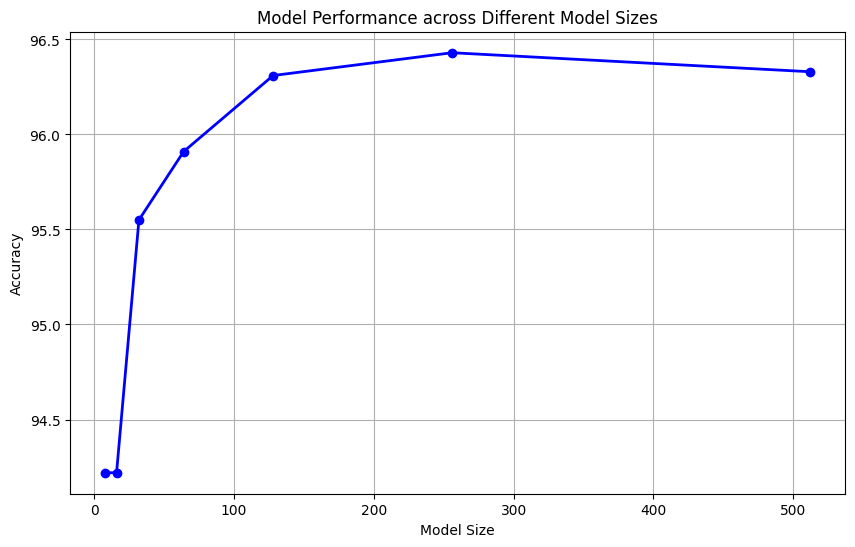

In [23]:
# Plot the accuracy of the model across different sizes
# This visualization shows how accuracy varies with model size, demonstrating scalability.

# Plotting the accuracy for different model sizes
plt.figure(figsize=(10, 6))
plt.plot(rep_sizes, top5_accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title("Model Performance across Different Model Sizes")
plt.xlabel("Model Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


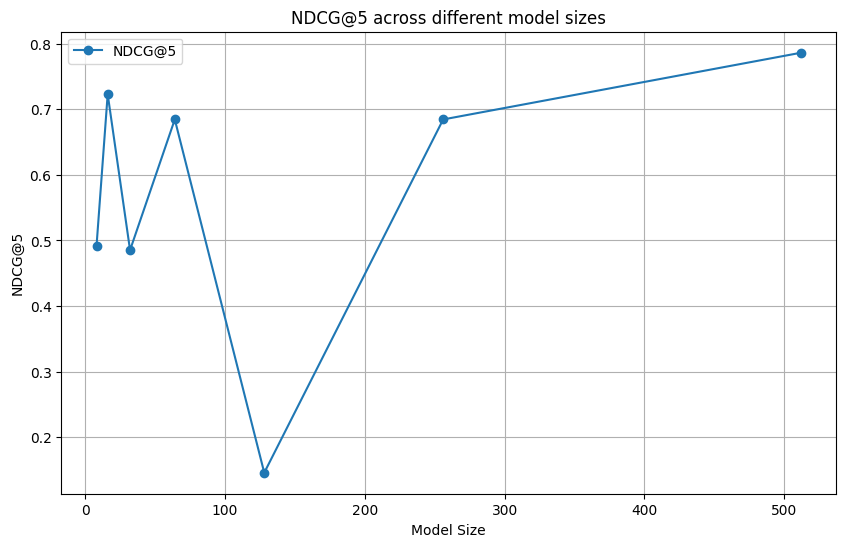

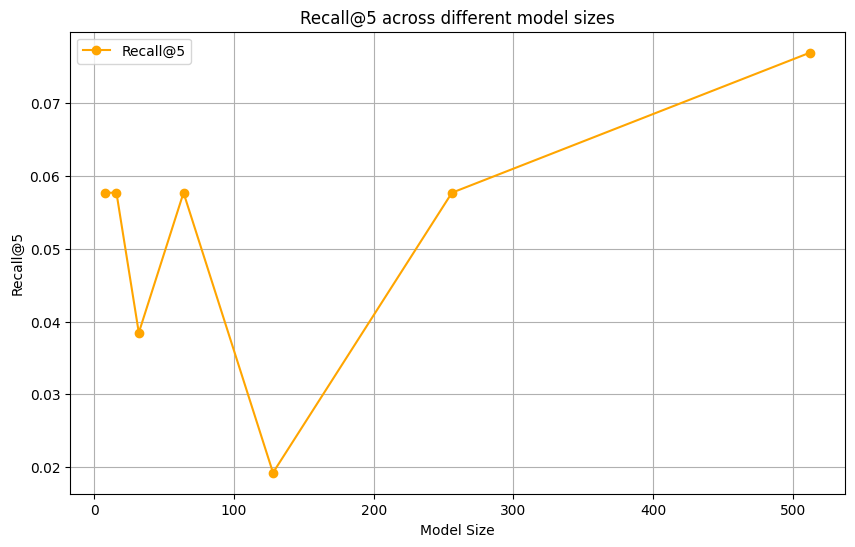

In [24]:

# Plot NDCG@5 and Recall@5 across model sizes based on results dictionary
model_sizes = list(results['ndcg'].keys())
ndcg_values = list(results['ndcg'].values())
recall_values = list(results['recall'].values())

# Plot NDCG@5
plt.figure(figsize=(10, 6))
plt.plot(model_sizes, ndcg_values, marker='o', linestyle='-', label="NDCG@5")
plt.xlabel("Model Size")
plt.ylabel("NDCG@5")
plt.title("NDCG@5 across different model sizes")
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall@5
plt.figure(figsize=(10, 6))
plt.plot(model_sizes, recall_values, marker='o', linestyle='-', color='orange', label="Recall@5")
plt.xlabel("Model Size")
plt.ylabel("Recall@5")
plt.title("Recall@5 across different model sizes")
plt.legend()
plt.grid(True)
plt.show()
